## Tutorial 12 - Optimize
Welcome to this tutorial outlining the Optimization process in RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs. It uses the pieces from tutorials 11 and 12 to create a simple optimization problem. 

---

## Header and Imports

The **Imports** section is divided into two parts: general-purpose Python libraries and simulation-specific libraries. Note, how the earlier tutorials are imported. 

---

In [1]:
# Optimize.py
# Created:  Feb 2016, M. Vegh
# Modified: Aug 2017, E. Botero
#           Aug 2018, T. MacDonald

# ----------------------------------------------------------------------        
#   Imports
# ----------------------------------------------------------------------    

import RCAIDE 
from RCAIDE.Framework.Core import Units, Data
import numpy as np


import import_ipynb
import Tutorial_15_Vehicle as Vehicles
import Tutorial_10_Analyses as Analyses
import Tutorial_11_Missions as Missions
import Tutorial_14_Procedure as Procedure
import Tutorial_13_Plot_Mission as Plot_Mission
import matplotlib.pyplot as plt
from RCAIDE.Framework.Optimization.Common import  Nexus
from RCAIDE.Framework.Optimization .Packages.scipy import scipy_setup 

Matplotlib created a temporary cache directory at /var/folders/r4/4h9x29hj6f95kyhjsltxc6_00000gn/T/matplotlib-fwch3wf2 because the default path (/Users/aidanmolloy/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


## Analysis Setup

The **setup** section creates the optimization problem through two parts: first defining the problem and its constraints and then appending the analyses and vehicle of interest.

---
### 1. Defining the Problem

The first step in defining the problem is to create the nexus and problem data sets. The nexus is a container for all the data sets and analyses and runs the optimization, while the problem data set is a container for the problem inputs, objectives, and constraints.

**`Problem.inputs`** defines the bounds for the optimization variables. The first column is the tag, the second is the initial value, the third is the lower bound, the fourth is the upper bound, the fifth is the scaling factor, and the sixth is the units. The scaling factor is used to scale variables to similar orders of magnitude. The optimization can sometimes fail if the variables are not of similar magnitude.

**`problem.objective`** defines the objective variable. The first column is the tag, the second is the scaling factor, and the third is the units. 

**`problem.constraints`** defines the constraints. The first column is the tag, the second is the sense, the third is the edge, the fourth is the scaling factor, and the fifth is the units. The sense is either '>', '<', or '='. The edge is the value of the constraint. Additional constraints can be be added by adding additional lists to the array.

**`problem.aliases`** defines the aliases. The first column is the tag, and the second is the list of data paths. The data paths are the paths to the data in the nexus. This indicated where the data referenced by the tags in **`problem.inputs`**,**`problem.objective`** and **`problem.constraints`** can be found.

---
### 2. Append Analyses and Vehicle

Here, the vehicle, analyses, missions, and procedure are appended to the nexus each within their own container. The summary container, where results are stored, is also created. 

---

In [2]:
def setup():

    nexus = Nexus()
    problem = Data()
    nexus.optimization_problem = problem

    # -------------------------------------------------------------------
    # Inputs
    # -------------------------------------------------------------------

    #   [ tag                   , initial,     lb , ub        , scaling , units ]
    problem.inputs = np.array([
        [ 'wing_area'           ,  92    ,    50. ,   130.    ,   100.  , 1*Units.meter**2],
        [ 'cruise_altitude'     ,   10    ,    8. ,    12.    ,   10.   , 1*Units.km],
    ],dtype=object)

    # -------------------------------------------------------------------
    # Objective
    # -------------------------------------------------------------------

    # [ tag, scaling, units ]
    problem.objective = np.array([
        [ 'fuel_burn', 10000, 1*Units.kg ]
    ],dtype=object)
    
    # -------------------------------------------------------------------
    # Constraints
    # -------------------------------------------------------------------
    
    # [ tag, sense, edge, scaling, units ]
    problem.constraints = np.array([
        [ 'design_range_fuel_margin' , '>', 0., 1E-1, 1*Units.less], #fuel margin defined here as fuel 
    ],dtype=object)
    
    # -------------------------------------------------------------------
    #  Aliases
    # -------------------------------------------------------------------
    
    # [ 'alias' , ['data.path1.name','data.path2.name'] ]

    problem.aliases = [
        [ 'wing_area'                        ,   ['vehicle_configurations.*.wings.main_wing.areas.reference',
                                                  'vehicle_configurations.*.reference_area'                    ]],
        [ 'cruise_altitude'                  , 'missions.base.segments.climb_3.altitude_end'                    ],
        [ 'fuel_burn'                        ,    'summary.base_mission_fuelburn'                               ],
        [ 'design_range_fuel_margin'         ,    'summary.max_zero_fuel_margin'                                ],
    ]    
    
    # -------------------------------------------------------------------
    #  Vehicles
    # -------------------------------------------------------------------
    nexus.vehicle_configurations = Vehicles.setup()
    
    # -------------------------------------------------------------------
    #  Analyses
    # -------------------------------------------------------------------
    nexus.analyses = Analyses.setup(nexus.vehicle_configurations)
    
    # -------------------------------------------------------------------
    #  Missions
    # -------------------------------------------------------------------
    nexus.missions = Missions.setup(nexus.analyses)
    
    # -------------------------------------------------------------------
    #  Procedure
    # -------------------------------------------------------------------    
    nexus.procedure = Procedure.setup()
    
    # -------------------------------------------------------------------
    #  Summary
    # -------------------------------------------------------------------    
    nexus.summary = Data()    
    nexus.total_number_of_iterations = 0
    return nexus
     

## Run the Setup

This excerpt runs the optimization function. 

It begins by defining the output, as the objective of the problem. 

It then calles the **scipy_setup** function, which is the optimization wrapper. This function splits the presented **`problem`** variable into the required format for scipy. The type of solver, a Sequential Least Squares Programming (SLSQP) solver, is also defined. For more information on the solver refer to the RCAIDE and scipy documentation.

Finally, mision results are plotted and value of the objective varibale are printed. Over the course of an optimization, these values will be continuously updated.

---

Inputs
[0.92 1.  ]
Obj
[0.77891368]
Inputs
[0.92000001 1.        ]
Obj
[0.78101932]
Inputs
[0.92       1.00000001]
Obj
[0.78101992]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7789136753961072
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
[0.92 1.  ]
fuel burn =  [7810.19924285]
fuel margin =  [8.6785417]


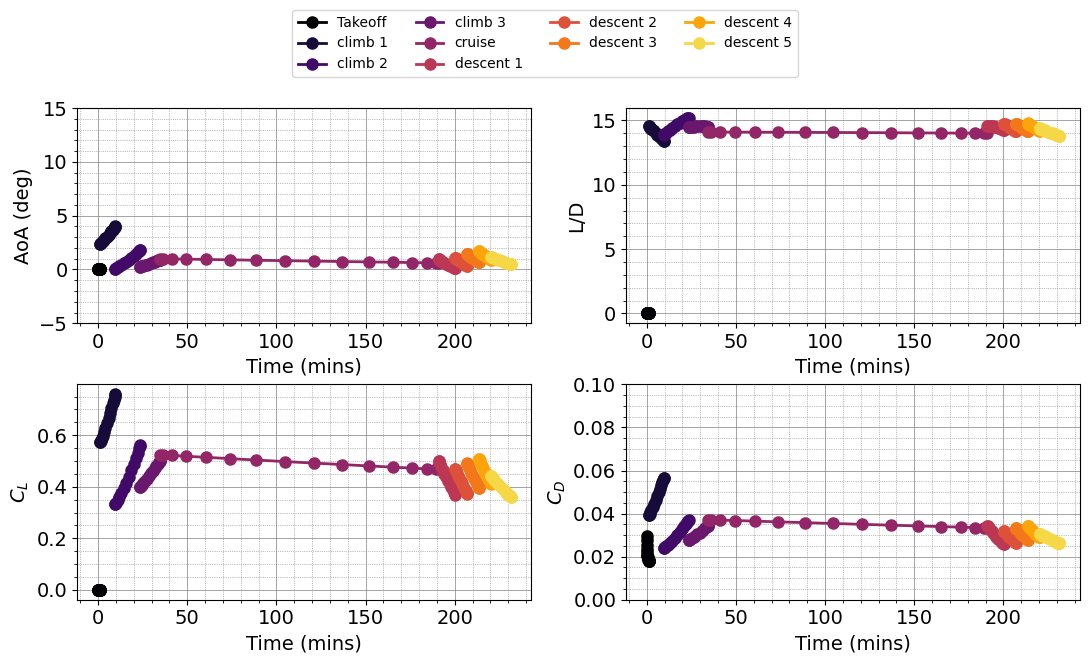

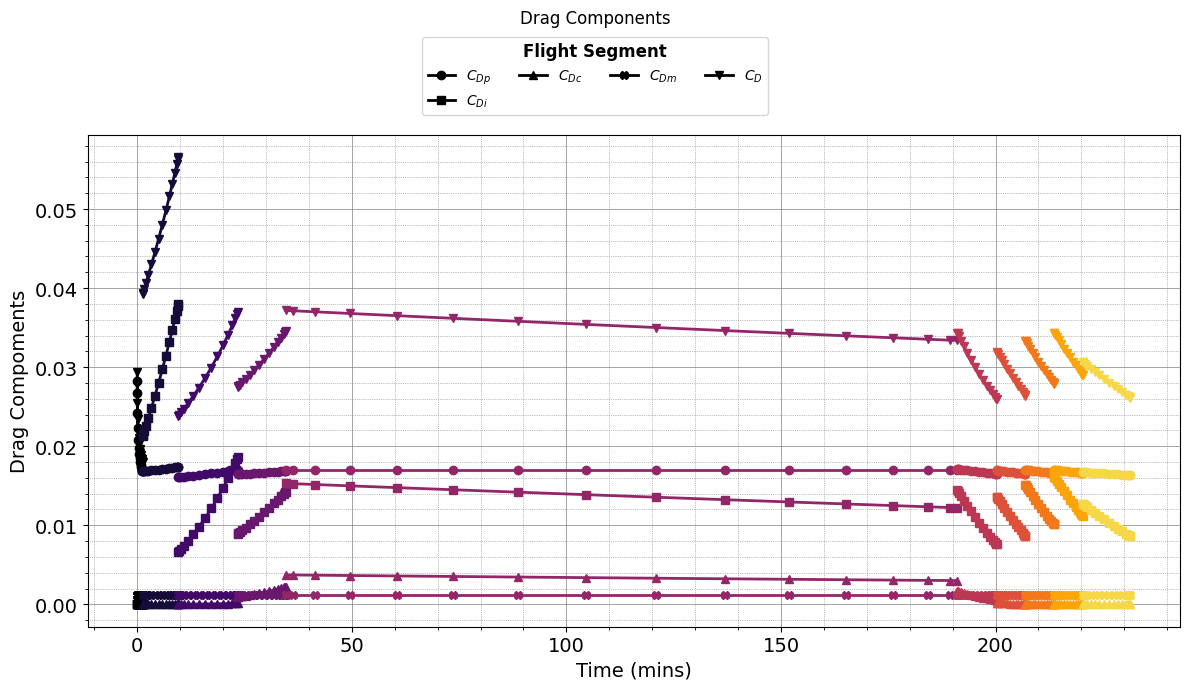

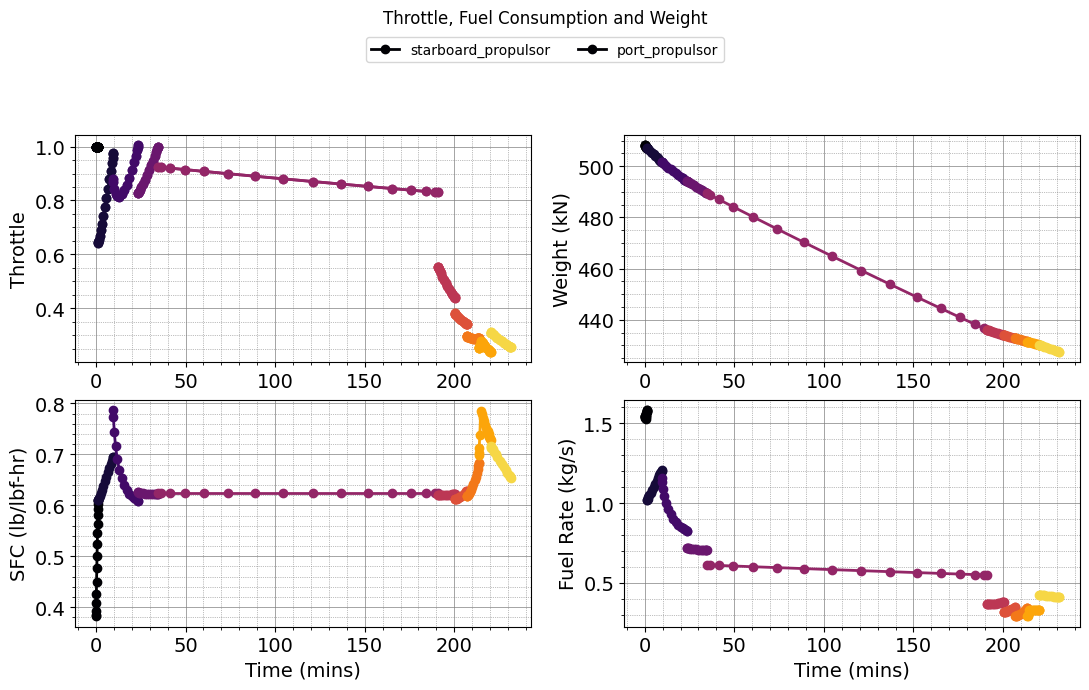

In [3]:
problem = setup()

## Base Input Values
output = problem.objective()
    
    
# Uncomment for the first optimization
output = scipy_setup.SciPy_Solve(problem,solver='SLSQP')
print (output)    

print('fuel burn = ', problem.summary.base_mission_fuelburn)
print('fuel margin = ', problem.all_constraints())

Plot_Mission.plot_mission(problem)
plt.show()